In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import scipy.stats as stats
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats.anova import anova_lm
import warnings
import statsmodels.api as sm

warnings.filterwarnings("ignore")

# Introduction

This study shows some of the results of the project degree i did for my title as chemical engineer, specifically the elaboration of the surface responses of removal percentage (% R) of levofloxacin with  non living microalgae chlorella,. sp (NLB) and modified after lipid extraction (LEB), and their respective analysis.  

### Description of Problem

Antibiotics such as levofloxacin belong to emerging contaminants whose presence in water bodies have harmful effects[1],  and classical treatment techniques are not enough to eliminate them. One possible solution is the adsorption technique with easily obtained biomaterials such as the microalgae chlorella sp. , obtained either directly by cultivation or as a by-product of other processes such as lipids extraction[2,3]. 

For all the above, it was asked which are the conditions of pH, initial concentration of levofloxacin and biomass to obtain a high  percentage removal in aqueous medium. 

### Description of Variables

* Levofloxacin: fluoroquinolone with great activity against gram positives and negatives bacterias. In its structure is present a zwitterion, which means that contains groups of both charges (carboxylic group and piperazine ring)[4]. In this project was used  non living biomass (NLB) obtained by cultivation, and lipid extracted biomass (LEB), brought by students from other thesis. 
* pH: concentration of the hydrogen H+ in logaritmic scale. This quantity is used to measure the acidity of solutions. 
* Chlorella sp.,: microalgae found in environments like water, sea, soil, etc. Its cultivation is done because the biomass has several applications as food and oil production and water treatment [5]. 

### General Insights of Experimental Design and results

The research was done with the following variables, and the data can be found in the experimental_design excel archive, in the variables sheet:

In [138]:
pd.set_option('display.max_colwidth', None) 
variables = pd.read_excel('experimental_design.xlsx', sheet_name = 'Variables')
variables 

,Independant Variable,Definition,Units
0,% R,Fraction between the difference of initials and finals concentration of levofloxacin divided by that initial concentration,Without dimensions
1,Dependant Variable,Definition,Units
2,c0,Initial concentration of levofloxacin,mg/L ( miligrams per liter)
3,m,Dosage of NLB and LEB,mg (miligrams)
4,pH,Measure of acidity in the solution,Without dimensions


The values used for each variable were:

In [140]:
values_variables = pd.read_excel('experimental_design.xlsx', sheet_name = 'Levels')
values_variables 

,Table of levels of experimental design,Levels,Levels.1,Levels.2,Levels.3,Levels.4,Levels.5,Levels.6
0,#,-3.0,-2.0,-1,0.0,1,2.0,3.0
1,c0 (mg/L),NaN,NaN,20,40.0,60,NaN,NaN
2,m (mg),NaN,NaN,25,50.0,75,NaN,NaN
3,pH,4.0,5.0,6,NaN,8,9.0,10.0


* They were employed six pH, three c0 and three m levels (6x3x3) for a total of 54 experiments for the NLB and LEB, resulting in a total of 108 experiments, to which their respective replicates were prepared, to finally have 216 experiments, using a complete factorial design.
* To lower the previous number it was used the OptimalDesign package present in R, with the D criteria[6]. The optimal quantity of experiments for this design matrix were 18, 36 and 54 with a D-value 0f 0.1765 for all of them. Therefore, for each biomass 18 experiments were done and they are shown in the next table:

In [154]:
number_of_experiments = pd.read_excel('experimental_design.xlsx', sheet_name = 'matrix', index_col = 'Number of experiment')
number_of_experiments.head()

,c0 (mg/L),m(mg),pH
Number of experiment,,,
1,20,25,5
2,20,25,9
3,40,25,4
4,40,25,10
5,60,25,6


The results of those experiments are saved in the xlsx files lebphi and nlbphi. Other critical steps, like the elaboration of the calibration curves, won't be discussed in the present study.

# Surface Response with OLS

Response surface methodology (RSM) uses statistics and mathematics to model the behavior of the response variable  in the function of two or more variables(predictors)[7]. Keeping in mind this methodology and with the results obtained, an OLS of a multi linear regression model with polynomial and interaction terms was performed to find which predictors have a statistically significant effect on the response. 

## % R Response of the LEB

In [8]:
response = input('')

 R


### Generation of interaction terms

In [10]:
lebphi = pd.read_excel('lebphi.xlsx')

In [11]:
lebphi.head()

,R,c0,m,pH
0,32.92,19.23,25,5.03
1,14.76,19.23,25,9.06
2,32.67,38.46,25,4.03
3,25.74,38.46,25,10.06
4,51.40,60.89,25,6.05


In [12]:
lebphi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       18 non-null     float64
 1   c0      18 non-null     float64
 2   m       18 non-null     int64  
 3   pH      18 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 708.0 bytes


Data inspection was fine, therefore it was divided in response and predictors variables, and the next script created the polynomial grade 2 terms with the lineal interactions. PolyFeatures from sklean could also be used for this step. Finally, the dataframes from those new terms and the response were merged. 

In [13]:
# Divide variables and answer q
X = lebphi.drop(axis = 1, columns = response).copy()
y = lebphi[response].copy()

In [14]:
# Generation of polynomial grade 2 terms 

#Interaction terms
product_df = pd.DataFrame()
for i, col1 in enumerate(X.columns):
    for j, col2 in enumerate(X.columns):
         if (i < j)  :  # Ensure each pair is only considered once
            product_column_name = f'{col1}{col2}'
            product_df[product_column_name] = X[col1] * X[col2]

# Cuadratic terms
for colname in X.columns:
    if colname != response:
        X2 = X[colname]**2
        X2_name = colname + "2"
        X.insert(loc= len(X.columns), column=X2_name, value=X2)
          
X_num = pd.concat([X, product_df], axis = 1)

In [15]:
# Concating predictors and response dataframes
r_smf = pd.concat([X_num, y], axis = 1)

In [16]:
r_smf.head()

,c0,m,pH,c02,m2,pH2,c0m,c0pH,mpH,R
0,19.23,25,5.03,369.7929,625,25.3009,480.75,96.7269,125.75,32.92
1,19.23,25,9.06,369.7929,625,82.0836,480.75,174.2238,226.50,14.76
2,38.46,25,4.03,1479.1716,625,16.2409,961.50,154.9938,100.75,32.67
3,38.46,25,10.06,1479.1716,625,101.2036,961.50,386.9076,251.50,25.74
4,60.89,25,6.05,3707.5921,625,36.6025,1522.25,368.3845,151.25,51.40


### Backward Elimination 

This script was done to eliminate all values which p|t| > 0.05 and then perform the final model with the respective ANOVA. Forward selection could also be used here. 

In [18]:
# Independent variables
independent_vars = set(r_smf.columns.sort_values())
independent_vars.remove(response)

# Backward elimination
pval_threshold = 0.05
highest_pval = 1

while (len(independent_vars) > 0) and (highest_pval > pval_threshold):
    regr_model = "R ~ " + ' + '.join(independent_vars)
    model = smf.ols(regr_model, r_smf).fit()
    pval_testmodel = model.pvalues
    highest_pval = pval_testmodel.drop('Intercept').max()
      
    if highest_pval > pval_threshold:
        # Remove the independent variable with the highest p-value
        var_to_remove = pval_testmodel.drop('Intercept').idxmax()
        independent_vars.remove(var_to_remove)

# Final model
independent_vars = sorted(independent_vars)
regr_model = "R ~ " + ' + '.join(independent_vars)
final_model = smf.ols(regr_model, r_smf).fit()
print(final_model.summary())

# Perform ANOVA 
anova_results_leb = anova_lm(final_model)
print(anova_results_leb)

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     72.58
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           1.51e-08
Time:                        07:46:36   Log-Likelihood:                -40.948
No. Observations:                  18   AIC:                             93.90
Df Residuals:                      12   BIC:                             99.24
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.1851      3.288      3.706      0.0

### Analysis of results

* Adj R of 0.955 and F-statistic of 72.58 showed a good fit of the model.
* m  had a strong positive effect on the response linearly, but its interaction with c0 reduced the response.
* c0 had a positive interaction with the pH, and an squared effect on the response, while the pH had the inverse effect.
* All PR(>F) values from all predictors showed that they reduce the unexplained variance. 

Nevertheless, some precisions should be made:
* t-test only measures if the coefficent of the predictor is significantly different from zero, but how significally is can't be answered.
* Condition number is large because data wasn't scaled: the goal of the study wasn't to find the most significally or optimal conditions. Therefore, it would be an error to say that m is the most important predictor.

## % R Response with NLB

### Generation of interaction terms

In [22]:
nlbphi = pd.read_excel('nlbphi.xlsx')

In [23]:
nlbphi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18 entries, 0 to 17
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       18 non-null     float64
 1   c0      18 non-null     float64
 2   m       18 non-null     int64  
 3   pH      18 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 708.0 bytes


In [24]:
nlbphi.head()

,R,c0,m,pH
0,0.00,19.23,25,5.05
1,12.81,19.23,25,9.04
2,0.00,38.46,25,4.01
3,19.29,38.46,25,10.06
4,32.78,60.89,25,6.05


In [25]:
# Divide variables and answer q
X_nlb = nlbphi.drop(axis = 1, columns = response).copy()
y_nlb = nlbphi[response].copy()

In [26]:
# Generation of polynomial grade 2 terms 
#Interaction terms
product_df_nlb = pd.DataFrame()
for i, col1 in enumerate(X_nlb.columns):
    for j, col2 in enumerate(X_nlb.columns):
         if (i < j)  :  # Ensure each pair is only considered once
            product_column_name = f'{col1}{col2}'
            product_df_nlb[product_column_name] = X_nlb[col1] * X_nlb[col2]

# Cuadratic terms
for colname in X_nlb.columns:
    if colname != response:
        X2_nlb = X_nlb[colname]**2
        X2_name_nlb = colname + "2"
        X_nlb.insert(loc= len(X_nlb.columns), column = X2_name_nlb, value = X2_nlb)
          
X_num_nlb = pd.concat([X_nlb, product_df_nlb], axis = 1)

In [27]:
# Concating predictors and response dataframes
r_smf_nlb = pd.concat([X_num_nlb, y_nlb], axis = 1)

In [28]:
r_smf_nlb.head()

,c0,m,pH,c02,m2,pH2,c0m,c0pH,mpH,R
0,19.23,25,5.05,369.7929,625,25.5025,480.75,97.1115,126.25,0.00
1,19.23,25,9.04,369.7929,625,81.7216,480.75,173.8392,226.00,12.81
2,38.46,25,4.01,1479.1716,625,16.0801,961.50,154.2246,100.25,0.00
3,38.46,25,10.06,1479.1716,625,101.2036,961.50,386.9076,251.50,19.29
4,60.89,25,6.05,3707.5921,625,36.6025,1522.25,368.3845,151.25,32.78


### Backward elimination

In [30]:
# Independent variables
independent_vars = set(r_smf_nlb.columns.sort_values())
independent_vars.remove(response)

# Backward elimination
pval_threshold = 0.05
highest_pval = 1

while (len(independent_vars) > 0) and (highest_pval > pval_threshold):
    regr_model = "R ~ " + ' + '.join(independent_vars)
    model = smf.ols(regr_model, r_smf_nlb).fit()
    pval_testmodel = model.pvalues
    highest_pval = pval_testmodel.drop('Intercept').max()
      
    if highest_pval > pval_threshold:
        # Remove the independent variable with the highest p-value
        var_to_remove = pval_testmodel.drop('Intercept').idxmax()
        independent_vars.remove(var_to_remove)

# Final model
independent_vars = sorted(independent_vars)
regr_model_nlb = "R ~ " + ' + '.join(independent_vars)
final_model_nlb = smf.ols(regr_model_nlb, r_smf_nlb).fit()
print(final_model_nlb.summary())

# Perform ANOVA 
anova_results_nlb = anova_lm(final_model_nlb)
print(anova_results_nlb)

                            OLS Regression Results                            
Dep. Variable:                      R   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.957
Method:                 Least Squares   F-statistic:                     75.84
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           1.17e-08
Time:                        07:46:37   Log-Likelihood:                -46.724
No. Observations:                  18   AIC:                             105.4
Df Residuals:                      12   BIC:                             110.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -92.1389     15.019     -6.135      0.0

### Analysis of results

* Adj R of 0.957 and F-statistic of 75.84 showed a good fit of the model.
* c0 and pH had a strong positive effect on the response linearly, but their interaction reduced the response.
* m effect was only present as an  positive interaction with the c0.
* pH showed an huge squared negative interaction on the response, as in the LEB.
* All PR(>F) values from all predictors showed that they reduce the unexplained variance. 

The precisions made in the LEB also can be applied for this analysis.

# Surface Plots Elaboration

* The elaboration of the 3D plots was done with the models obtained in the previous step. Because there are 3 predictors, they were made by keeping one of them constant. 
* First the data was extracted and then arranged in a meshgrid; after that, a function with a model was defined to insert the meshgrid data to obtain the values for the z-axis; finally, all those arrays were ploted using the plot_surface method. 

### LEB terms extraction

In [34]:
max_R_row = r_smf.loc[r_smf[response].idxmax()]

min_m = r_smf.loc[r_smf['m'].idxmin()].loc['m']
max_m = r_smf.loc[r_smf['m'].idxmax()].loc['m']

min_c0 = r_smf.loc[r_smf['c0'].idxmin()].loc['c0']
max_c0 = r_smf.loc[r_smf['c0'].idxmax()].loc['c0']

min_pH = r_smf.loc[r_smf['pH'].idxmin()].loc['pH']
max_pH = r_smf.loc[r_smf['pH'].idxmax()].loc['pH']

In [35]:
# Getting predictors range 
c0_range = np.linspace(min_c0, max_c0, 100) 
m_range = np.linspace(min_m, max_m, 100)   
pH_range = np.linspace(min_pH, max_pH, 100) 

# Getting the constants 
c0_constant = np.full_like(c0_range, max_R_row.loc['c0'])
m_constant = np.full_like(m_range, max_R_row.loc['m']) 
pH_constant = np.full_like(pH_range, max_R_row.loc['pH']) 

In [36]:
# Extracting constants from the model
fm = final_model.params

In [37]:
fm

Intercept    12.185063
c02           0.005635
c0m          -0.009114
c0pH          0.054941
m             0.814631
pH2          -0.272970
dtype: float64

In [38]:
c0 = np.array(c0_range)
m = np.array(m_range)     
pH = np.array(pH_range)

In [39]:
# Defining prediction Response function for predictors range
def predict_R_leb(c0, m, pH):
    return fm[0] + fm[1]*c0*c0 + fm[2]*c0*m + fm[3]*c0*pH + fm[4]*m + fm[5]*pH*pH

In [40]:
# Elaboration of data for surfaces 3D

# Data for surface with c0 constant
m_mesh_c0, pH_mesh_c0 = np.meshgrid(m_range, pH_range)
R_mesh_c0 = predict_R_leb(c0_constant, m_mesh_c0, pH_mesh_c0)

# Data for surface with m constant
c0_mesh_m, pH_mesh_m = np.meshgrid(c0_range, pH_range)
R_mesh_m = predict_R_leb(c0_mesh_m, m_constant, pH_mesh_m)

# Data for surface with pH constant
c0_mesh_pH, m_mesh_pH = np.meshgrid(c0_range, m_range)
R_mesh_pH = predict_R_leb(c0_mesh_pH, m_mesh_pH, pH_constant)

### NLB terms extraction

In [42]:
max_R_row_nlb = r_smf_nlb.loc[r_smf_nlb[response].idxmax()]

min_m_nlb = r_smf_nlb.loc[r_smf_nlb['m'].idxmin()].loc['m']
max_m_nlb = r_smf_nlb.loc[r_smf_nlb['m'].idxmax()].loc['m']

min_c0_nlb = r_smf_nlb.loc[r_smf_nlb['c0'].idxmin()].loc['c0']
max_c0_nlb = r_smf_nlb.loc[r_smf_nlb['c0'].idxmax()].loc['c0']

min_pH_nlb = r_smf_nlb.loc[r_smf_nlb['pH'].idxmin()].loc['pH']
max_pH_nlb = r_smf_nlb.loc[r_smf_nlb['pH'].idxmax()].loc['pH']

In [43]:
# Getting predictors range 
c0_range_nlb = np.linspace(min_c0_nlb, max_c0_nlb, 100) 
m_range_nlb = np.linspace(min_m_nlb, max_m_nlb, 100)   
pH_range_nlb = np.linspace(min_pH_nlb, max_pH_nlb, 100) 

# Getting the constants 
c0_constant_nlb = np.full_like(c0_range_nlb, max_R_row_nlb.loc['c0'])
m_constant_nlb = np.full_like(m_range_nlb, max_R_row_nlb.loc['m']) 
pH_constant_nlb = np.full_like(pH_range_nlb, max_R_row_nlb.loc['pH']) 

In [44]:
# Extracting constants from the model
fm_nlb = final_model_nlb.params

In [45]:
c0_nlb = np.array(c0_range_nlb)
m_nlb = np.array(m_range_nlb)     
pH_nlb = np.array(pH_range_nlb)

In [46]:
fm_nlb

Intercept   -92.138868
c0            0.840121
c0m           0.009582
c0pH         -0.064398
pH           20.906159
pH2          -1.123360
dtype: float64

In [47]:
# Defining prediction R function for predictors range
def predict_R_nlb(c0, m, pH):
    return fm_nlb[0] + fm_nlb[1]*c0 + fm_nlb[2]*c0*m + fm_nlb[3]*c0*pH +fm_nlb[4]*pH + fm_nlb[5]*pH*pH

In [48]:
# Elaboration of data for surfaces 3D

# Data for surface with c0 constant
m_mesh_c0_nlb, pH_mesh_c0_nlb = np.meshgrid(m_range_nlb, pH_range_nlb)
R_mesh_c0_nlb = predict_R_nlb(c0_constant_nlb, m_mesh_c0_nlb, pH_mesh_c0_nlb)

# Data for surface with m constant
c0_mesh_m_nlb, pH_mesh_m_nlb = np.meshgrid(c0_range_nlb, pH_range_nlb)
R_mesh_m_nlb = predict_R_nlb(c0_mesh_m_nlb, m_constant_nlb, pH_mesh_m_nlb)

# Data for surface with pH constant
c0_mesh_pH_nlb, m_mesh_pH_nlb = np.meshgrid(c0_range_nlb, m_range_nlb)
R_mesh_pH_nlb = predict_R_nlb(c0_mesh_pH_nlb, m_mesh_pH_nlb, pH_constant_nlb)

### Graphs

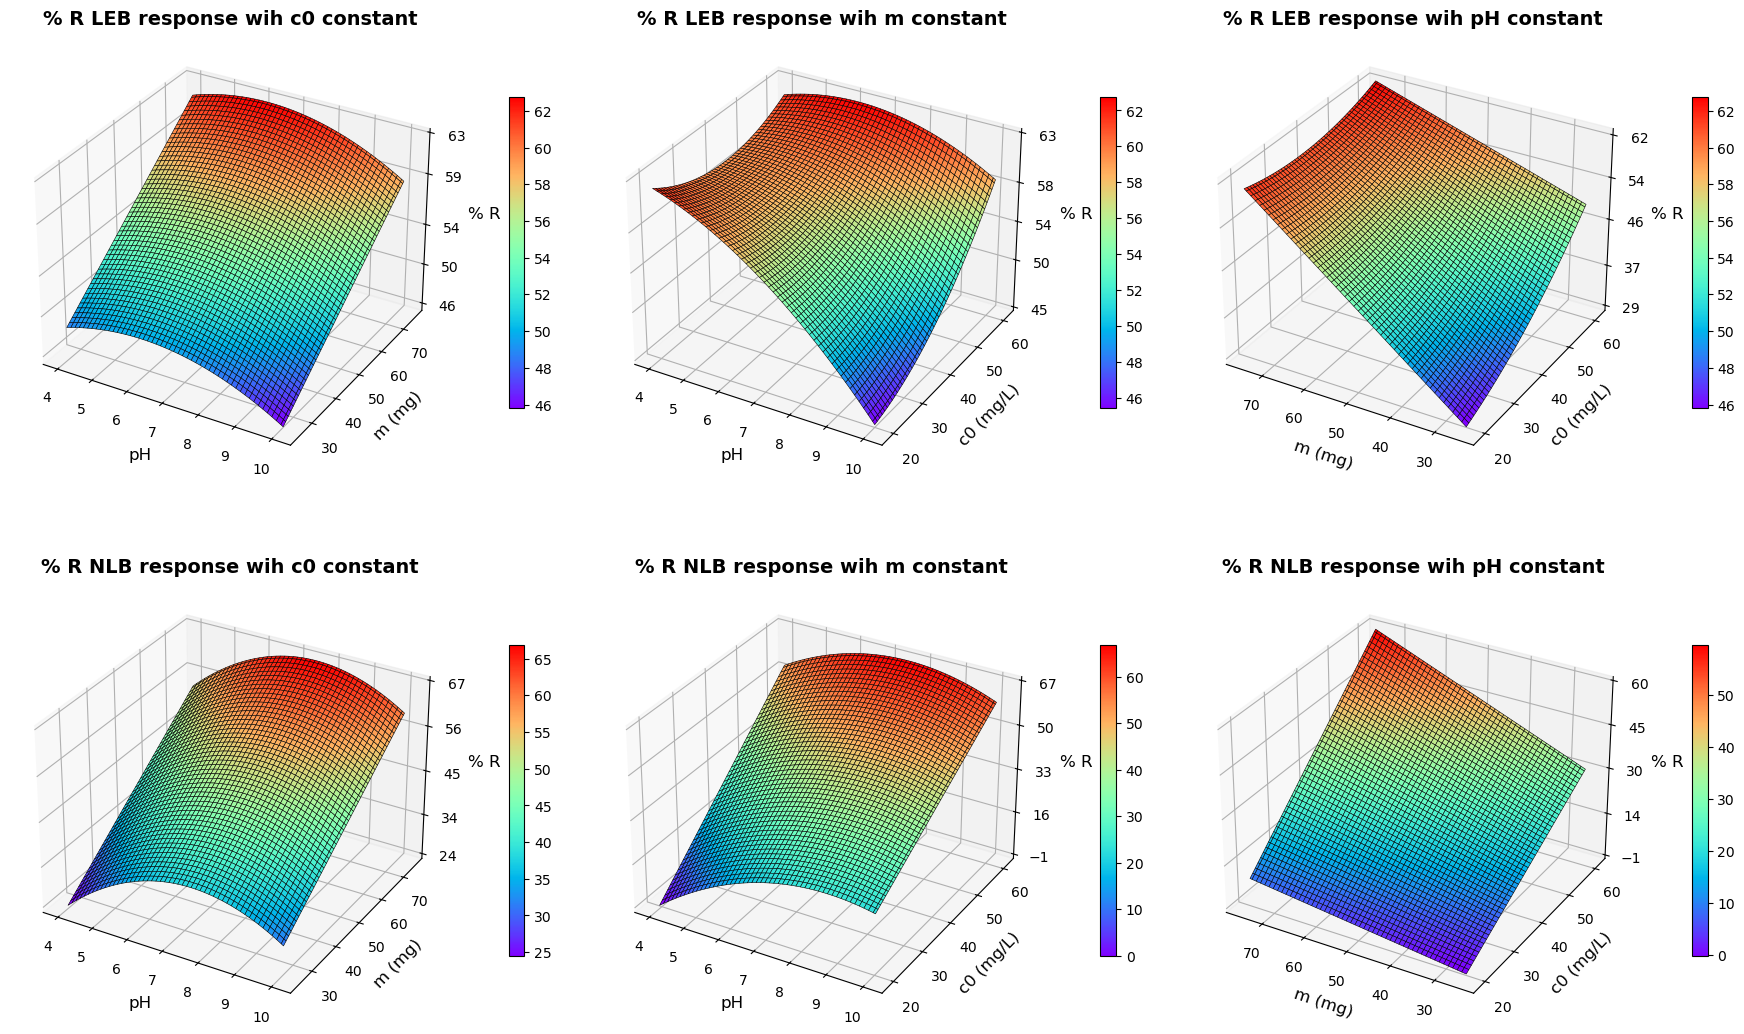

In [195]:
# Create a figure for 6 subplots in a 2x3 grid
fig = plt.figure(figsize=(18, 12))

# Plot 1
ax1 = fig.add_subplot(231, projection = '3d')
surface1 = ax1.plot_surface(pH_mesh_c0, m_mesh_c0, R_mesh_c0, cmap = 'rainbow', edgecolor = 'black', linewidth = 0.4)
ax1.set_xlabel('pH', fontsize = 12, labelpad = 5)
ax1.set_ylabel('m (mg)', fontsize = 12, labelpad = 5)
ax1.set_zlabel('% R', fontsize = 12, labelpad = 5)
ax1.set_title('% R LEB response wih c0 constant', fontsize = 14, weight = 'bold')
fig.colorbar(surface1, ax = ax1, shrink = 0.5, pad = 0.1)
z_min1, z_max1 = np.min(R_mesh_c0), np.max(R_mesh_c0)
ax1.set_zticks(np.round(np.linspace(z_min1, z_max1, 5)))

# Plot 2
ax2 = fig.add_subplot(232, projection = '3d')
surface2 = ax2.plot_surface(pH_mesh_m, c0_mesh_m, R_mesh_m, cmap = 'rainbow', edgecolor = 'black', linewidth = 0.4)
ax2.set_xlabel('pH', fontsize = 12, labelpad = 5)
ax2.set_ylabel('c0 (mg/L)', fontsize = 12, labelpad = 5)
ax2.set_zlabel('% R', fontsize = 12, labelpad = 5)
ax2.set_title('% R LEB response wih m constant', fontsize = 14, weight = 'bold')
fig.colorbar(surface2, ax = ax2, shrink = 0.5, pad = 0.1)
z_min2, z_max2 = np.min(R_mesh_m), np.max(R_mesh_m)
ax2.set_zticks(np.round(np.linspace(z_min2, z_max2, 5)))

# Plot 3
ax3 = fig.add_subplot(233, projection = '3d')
surface3 = ax3.plot_surface(m_mesh_pH, c0_mesh_pH, R_mesh_pH, cmap = 'rainbow', edgecolor = 'black', linewidth = 0.4)
ax3.set_xlabel('m (mg)', fontsize = 12, labelpad = 5)
ax3.set_ylabel('c0 (mg/L)', fontsize = 12, labelpad = 5)
ax3.set_zlabel('% R', fontsize = 12, labelpad = 5)
ax3.set_title('% R LEB response wih pH constant', fontsize = 14, weight = 'bold')
ax3.invert_xaxis()
fig.colorbar(surface1, ax = ax3, shrink = 0.5, pad = 0.1)
z_min3, z_max3 = np.min(R_mesh_pH), np.max(R_mesh_pH)
ax3.set_zticks(np.round(np.linspace(z_min3, z_max3, 5)))

# Plot 4
ax4 = fig.add_subplot(234, projection = '3d')
surface4 = ax4.plot_surface(pH_mesh_c0_nlb, m_mesh_c0_nlb, R_mesh_c0_nlb, cmap = 'rainbow', edgecolor = 'black', linewidth = 0.4)
ax4.set_xlabel('pH', fontsize = 12, labelpad = 5)
ax4.set_ylabel('m (mg)', fontsize = 12, labelpad = 5)
ax4.set_zlabel('% R', fontsize = 12, labelpad = 5)
ax4.set_title('% R NLB response wih c0 constant', fontsize = 14, weight = 'bold')
fig.colorbar(surface4, ax = ax4, shrink = 0.5, pad = 0.1)
z_min4, z_max4 = np.min(R_mesh_c0_nlb), np.max(R_mesh_c0_nlb)
ax4.set_zticks(np.round(np.linspace(z_min4, z_max4, 5)))

# Plot 5
ax5 = fig.add_subplot(235, projection = '3d')
surface5 = ax5.plot_surface(pH_mesh_m_nlb, c0_mesh_m_nlb, R_mesh_m_nlb, cmap = 'rainbow', edgecolor = 'black', linewidth = 0.4)
ax5.set_xlabel('pH', fontsize = 12, labelpad = 5)
ax5.set_ylabel('c0 (mg/L)', fontsize = 12, labelpad = 5)
ax5.set_zlabel('% R', fontsize = 12, labelpad = 5)
ax5.set_title('% R NLB response wih m constant', fontsize = 14, weight = 'bold')
fig.colorbar(surface5, ax = ax5, shrink = 0.5, pad = 0.1)
z_min5, z_max5 = np.min(R_mesh_m_nlb), np.max(R_mesh_m_nlb)
ax5.set_zticks(np.round(np.linspace(z_min5, z_max5, 5)))


# Plot 6
ax6 = fig.add_subplot(236, projection = '3d')
surface6 = ax6.plot_surface(m_mesh_pH_nlb, c0_mesh_pH_nlb, R_mesh_pH_nlb, cmap = 'rainbow', edgecolor = 'black', linewidth = 0.4)
ax6.set_xlabel('m (mg)', fontsize = 12, labelpad = 5)
ax6.set_ylabel('c0 (mg/L)', fontsize = 12, labelpad = 5)
ax6.set_zlabel('% R', fontsize = 12, labelpad = 5)
ax6.set_title('% R NLB response wih pH constant', fontsize = 14, weight = 'bold')
fig.colorbar(surface6, ax = ax6, shrink = 0.5, pad = 0.1)
z_min6, z_max6 = np.min(R_mesh_pH_nlb), np.max(R_mesh_pH_nlb)
ax6.set_zticks(np.round(np.linspace(z_min6, z_max6, 5)))
ax6.invert_xaxis()

# Adjust layout t
plt.tight_layout()
plt.show()

### Comparison and analysis of graphs

* The response for both biomasses when c0 is constant is similar: a non linear relationship where the % R value is maximum between pH of 6 and 8 for m = 70 mg. This is because the bigger quantity of biomass the more availibily of active sites, and at this pH range the antibiotic is in zwitterion form, so the interaction of the functional groups between the algae and the Levofloxacin turns more favorable.
* For the NLB keeping m constant the graph is similar to the above, with a similar explanation, but the response becomes nule at the lowest concentration of c0 at pH = 4, and that's because the biggest competence for active sites of the groups of levofloxacin that are present as a cation in majority. Nevertheless, the LEB showed the inverse behaviour in this area, and that's product of the appearance of new sites after the lipid extraction, improving the response overall in the whole pH and c0 range.
* Finally, the % R for both biomasses keeping the pH constant is similar: almost a linear (folded sheet) relationship where the answer is improved with bigger values in both of them, and that's because the greater the numbers the more avaibility of active sites and chemical species to interact between the algae and the antibiotic. But, should be pointed that for LEB the response is improved for the whole range of m = 70, product of the lipid extraction.

As a side note, all the graphs have a similar behaviour: similar maximum % R but better response for the LEB in the whole interval of predictors, product of the modification process explained before.

# Acknowledgements

* To the teachers that brought me guideness and support in this project: Nestor Cubillán, Eduardo Angulo, Alberto Albis and Iván Mercado.
* To my thesis partner Karla Berrio.

# References

* [1] L. Rizzo et al., Urban wastewater treatment plants as hotspots for antibiotic resistant bacteria and genes spread into the environment: A review, Sci. Total Environ., vol. 447, pp. 345-360, mar. 2013, doi: 10.1016/j.scitotenv.2013.01.032.
* [2] E. Angulo, L. Bula, I. Mercado, A. Montaño, y N. Cubillán, Bioremediation of Cephalexin with non-living Chlorella sp., biomass after lipid extraction, Bioresour. Technol., vol. 257, pp. 17-22, jun. 2018, doi: 10.1016/j.biortech.2018.02.079.
* [3] Y. Wang et al., Perspectives on the feasibility of using microalgae for industrial wastewater treatment, Bioresour. Technol., vol. 222, pp. 485-497, dic. 2016, doi: 10.1016/j.biortech.2016.09.106.
* [4] CIOBANU, Gabriela; HARJA, Maria. Studies on the sorption of levofloxacin from aqueous solutions onto nanohydroxyapatite. Revue Roumaine de Chimie, 2018, vol. 63, no 63, p. 593-601. 
* [5] J. Liu y F. Chen,  Biology and Industrial Applications of Chlorella: Advances and Prospects, en Microalgae Biotechnology, C. Posten y S. Feng Chen, Eds., en Advances in Biochemical Engineering/Biotechnology, vol. 153. Cham: Springer International Publishing, 2014, pp. 1-35. doi: 10.1007/10_2014_286
* [6] https://cran.r-project.org/web/packages/OptimalDesign/OptimalDesign.pdf
* [7] Rosa Rodriguez, Germán Mazza, Daniela Zalazar-García, Anabel Fernandez, M. Paula Fabani,. Polyphenol extraction from bio-wastes: optimization and kinetic analysis. Studies in Natural Products Chemistry, Volume 79. 2023. pp 317-339. doi: https://doi.org/10.1016/B978-0-443-18961-6.00010-X